In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import psutil
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
from statistics import mean
import subprocess
import threading

In [2]:
# Cargar el modelo TorchScript
model = torch.jit.load("model.pt", map_location=torch.device('cpu'))
model.eval()

RecursiveScriptModule(
  original_name=TraditionalNet
  (activation): RecursiveScriptModule(original_name=ReLU)
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=BatchNorm2d)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=BatchNorm2d)
    (7): RecursiveScriptModule(original_name=Conv2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=BatchNorm2d)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=MaxPool2d)
    (12): RecursiveScriptModule(original_name=ReLU)
    (13): RecursiveScriptModule(original_name=BatchNorm2d)
    (14): RecursiveScriptModule(original_name=Conv2d)
    

In [3]:
# Definir las transformaciones (deben coincidir con las usadas en entrenamiento)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar el conjunto de test de CIFAR10
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Crear un subconjunto con sólo 10 imágenes (por ejemplo, las primeras 10)
subset_indices = list(range(10))
test_subset = Subset(test_dataset, subset_indices)

# Crear un DataLoader para el subconjunto
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

100.0%


In [4]:
ram_usage, cpu_usage = [], []
flg_monitoring = True

def clean_usages():
    global ram_usage, cpu_usage
    ram_usage = []
    cpu_usage = []

def monitorear_recursos(interval=1):
  global flg_monitoring
  global ram_usage, cpu_usage
  clean_usages()
  flg_monitoring = True
  while flg_monitoring:
    # Información de GPU
    #gpus = GPUtil.getGPUs()
    #gpu_info = []
    #for gpu in gpus:
    #    gpu_usage.append(gpu.load * 100)
    #    gpu_ram_usage.append(gpu.memoryUsed)
    #power_usage.append(get_gpu_power())
    # Información de CPU y RAM
    cpu_usage_now = psutil.cpu_percent(interval=0.1)
    cpu_usage.append(cpu_usage_now)
    ram_info = psutil.virtual_memory()
    ram_usage.append(ram_info.used)
    # power cpu
    # Pausar entre iteraciones
    time.sleep(interval)


def plot_usages(path):
    global ram_usage, cpu_usage
    print(f"max cpu: {max(cpu_usage)}, avg cpu: {mean(cpu_usage)}")
    print(f"max ram: {max(ram_usage)}, avg ram: {mean(ram_usage)}")
    fig = plt.figure(figsize=(20, 16))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.5])  # Tres filas, dos columnas

    # Primeras cuatro gráficas en una cuadrícula 2x2
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

    # Graficar cada serie de datos
    ax1.plot(cpu_usage)
    ax1.set_title('Uso de CPU')
    ax1.set_xlabel('Tiempo (segundos)')
    ax1.set_ylabel('Uso de CPU (%)')

    ax2.plot(ram_usage)
    ax2.set_title('Uso de RAM')
    ax2.set_xlabel('Tiempo (segundos)')
    ax2.set_ylabel('Uso de RAM (bytes)')

    plt.tight_layout()  # Ajusta los espacios automáticamente
    plt.show()

    # save figure in path
    plt.savefig(path)
    all_values = {
        "cpu_usage": cpu_usage,
        "avg_cpu_usage": mean(cpu_usage),
        "max_cpu_usage": max(cpu_usage),
        "ram_usage": ram_usage,
        "avg_ram_usage": mean(ram_usage),
        "max_ram_usage": max(ram_usage),
    }
    plt.show()
    return all_values

In [5]:
def inference():
    print("Iniciando inferencia")
    # Realizar inferencias sobre las 10 imágenes
    for i, (inputs, labels) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs)
            predicted_class = outputs.argmax(dim=1).item()
        print(f"Imagen {i+1}: Predicción: {predicted_class}, Etiqueta real: {labels.item()}")
    print("Inferencia finalizada")

Iniciando inferencia
Imagen 1: Predicción: 3, Etiqueta real: 3
Imagen 2: Predicción: 8, Etiqueta real: 8
Imagen 3: Predicción: 8, Etiqueta real: 8
Imagen 4: Predicción: 0, Etiqueta real: 0
Imagen 5: Predicción: 6, Etiqueta real: 6
Imagen 6: Predicción: 6, Etiqueta real: 6
Imagen 7: Predicción: 1, Etiqueta real: 1
Imagen 8: Predicción: 6, Etiqueta real: 6
Imagen 9: Predicción: 3, Etiqueta real: 3
Imagen 10: Predicción: 1, Etiqueta real: 1
Inferencia finalizada
Tiempo de inferencia: 0.26776599884033203
max cpu: 55.0, avg cpu: 55.0
max ram: 3966025728, avg ram: 3966025728


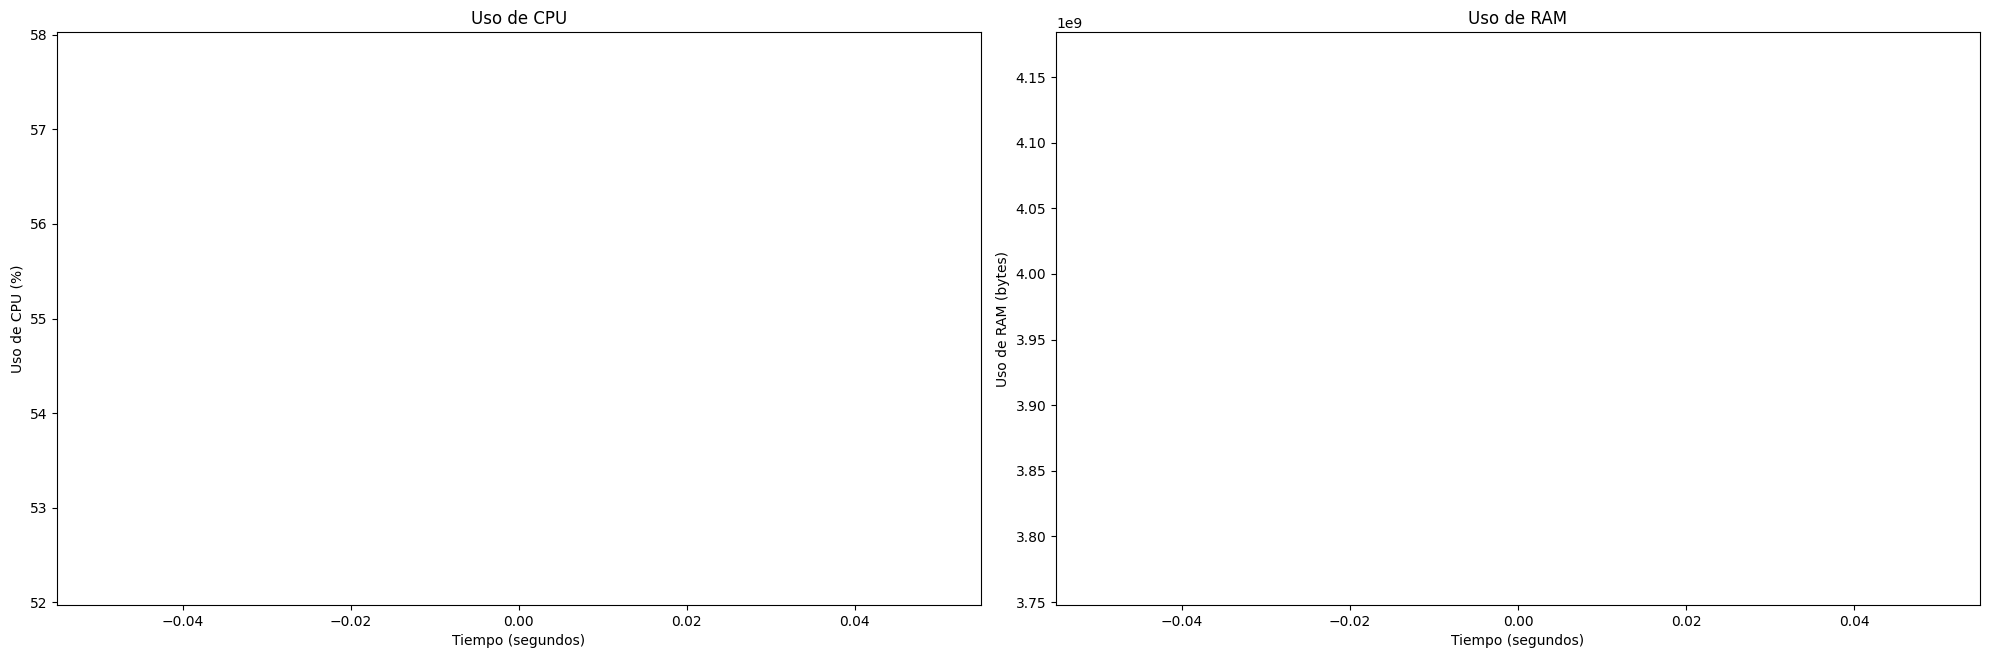

<Figure size 640x480 with 0 Axes>

{'cpu_usage': [55.0],
 'avg_cpu_usage': 55.0,
 'max_cpu_usage': 55.0,
 'ram_usage': [3966025728],
 'avg_ram_usage': 3966025728,
 'max_ram_usage': 3966025728}

In [6]:
monitor_thread = threading.Thread(target=monitorear_recursos)
inferece_thread = threading.Thread(target=inference)
monitor_thread.start()
start = time.time()
inferece_thread.start()
inferece_thread.join()
end = time.time()
print(f"Tiempo de inferencia: {end - start}")
flg_monitoring = False
plot_usages("./usages")